In [1]:
import os
import pandas as pd
from project.input.resources import resources_data
from project.model import get_inputs
from project.utils import cumulated_plot, cumulated_plots, plot_attribute, subplots_attributes, subplots_pie, reindex_mi
from project.building import AgentBuildings


# Comparing Profeel with SDES data
- General description
- Annual consumption
- thermal resistence
- cost curves and mac curves

In [68]:
path = 'output/static'
if not os.path.isdir(path):
    os.mkdir(path)

inputs = get_inputs(path)
buildings = inputs['buildings']

inputs = get_inputs(path=path, building_stock='project/input/stock/building_stock_profeel_final.csv')
profeel = inputs['buildings']


2022-11-25 15:26:56,506 - 7133 - log_static - INFO - Creating AgentBuildings object
2022-11-25 15:26:56,506 - 7133 - log_static - INFO - Creating AgentBuildings object
2022-11-25 15:26:57,607 - 7133 - log_static - INFO - Creating AgentBuildings object
2022-11-25 15:26:57,607 - 7133 - log_static - INFO - Creating AgentBuildings object
2022-11-25 15:26:57,607 - 7133 - log_static - INFO - Creating AgentBuildings object


## General stock description

In [5]:
stock = profeel.simplified_stock(energy_level=True)

stock


Occupancy status  Income owner  Income tenant  Housing type   Heating system                  Energy       Performance
Owner-occupied    D1            D1             Multi-family   Electricity-Performance boiler  Electricity  D              64591.036610
                                                                                                           E               9785.626702
                                                                                                           G              41840.860759
                                                              Natural gas-Standard boiler     Natural gas  C               1796.548661
                                                                                                           D               7623.223411
                                                                                                                              ...     
Social-housing    D10           D9             Single-family  Natural g

In [6]:
stock = stock.groupby(
    ['Occupancy status', 'Income owner', 'Income tenant', 'Housing type', 'Energy', 'Performance']).sum()


KeyError: "['Oil fuel'] not in index"

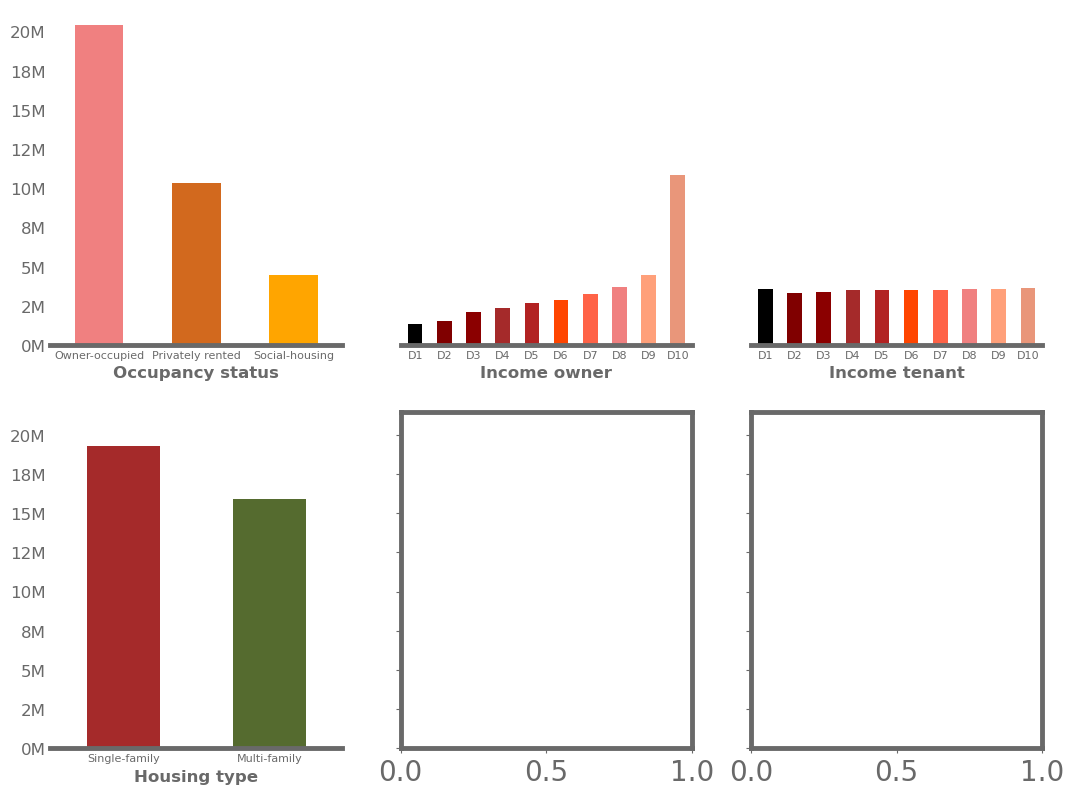

In [7]:
subplots_attributes(stock, dict_order=resources_data['index'], dict_color=resources_data['colors'], percent=False,
                    sharey=True)
subplots_attributes(stock, dict_order=resources_data['index'], dict_color=resources_data['colors'], percent=False,
                    sharey=True, save='output')

In [ ]:
subplots_pie(stock, dict_order=resources_data['index'], pie=['Housing type', 'Energy', 'Occupancy status'], dict_color=resources_data['colors'], percent=False)

## Thermal transmittance description

In [ ]:
temp = dict()
for i in ['Wall', 'Floor', 'Roof', 'Windows']:
    y = pd.Series(profeel.stock.index.get_level_values(i), index=profeel.stock.index,
               name='{} insulation (W/m2.K)'.format(i)).astype('float')
    x = profeel.stock / 10 ** 6
    temp.update({i: cumulated_plot(x, y, plot=False)})

cumulated_plots(temp, 'Thermal transmittance U (W/m2.K)', ylim=3)

In [ ]:
temp = dict()
for i in ['Wall', 'Floor', 'Roof', 'Windows']:
    y = pd.Series(buildings.stock.index.get_level_values(i), index=buildings.stock.index,
                  name='{} insulation (W/m2.K)'.format(i)).astype('float')
    x = buildings.stock / 10 ** 6
    temp.update({i: cumulated_plot(x, y, plot=False)})

cumulated_plots(temp, 'Thermal transmittance U (W/m2.K)', ylim=3)

Comment the comparison:


# Marginal abatement cost curves

##### Selecting one gesture by segments

In [ ]:
insulation = {'Wall': (True, False, False, False), 'Floor': (False, True, False, False), 'Roof': (False, False, True, False), 'Windows': (False, False, False, True), 'Global': (True, True, True, True)}

In [69]:
energy_prices = inputs['energy_prices']
cost_insulation = inputs['cost_insulation']
carbon_emission = inputs['carbon_emission']
carbon_value_kwh = inputs['carbon_value_kwh']
health_cost = inputs['health_cost']



##### Hummels method

In [ ]:
    def mitigation_potential(self, prices, cost_insulation_raw, carbon_emission=None, carbon_value=None, health_cost=None,
                             index=None):
        """Function returns bill saved and cost for buildings stock retrofit.

        Not implemented yet but should be able to calculate private and social indicator.
        Make cost abatement cost graphs, payback period graphs.

        Parameters
        ----------
        index
        prices
        cost_insulation_raw
        carbon_emission
        carbon_value
        health_cost

        Returns
        -------

        """

        output = dict()

        if index is None:
            index = self.stock.index

        consumption_before = self.consumption_standard(index)[0]
        consumption_after, _, certificate_after = self.prepare_consumption(self._choice_insulation, index=index)
        consumption_saved = (consumption_before - consumption_after.T).T

        self._efficiency.index.names = ['Heating system']
        efficiency = reindex_mi(self._efficiency, consumption_before.index)
        need_before = consumption_before * efficiency

        consumption_before = reindex_mi(consumption_before, index)
        need_before = reindex_mi(need_before, index)
        consumption_after = reindex_mi(consumption_after, index)
        consumption_saved = reindex_mi(consumption_saved, index)
        efficiency = reindex_mi(self._efficiency, consumption_saved.index)
        need_saved = (consumption_saved.T * efficiency).T

        consumption_actual_before = self.consumption_actual(prices.loc[self.year, :], consumption_before)
        consumption_actual_after = self.consumption_actual(prices.loc[self.year, :], consumption_after)
        consumption_actual_saved = (consumption_actual_before - consumption_actual_after.T).T

        consumption_before = reindex_mi(self._surface, index) * consumption_before
        consumption_after = (reindex_mi(self._surface, index) * consumption_after.T).T
        consumption_saved = (reindex_mi(self._surface, index) * consumption_saved.T).T

        need_before = reindex_mi(self._surface, index) * need_before
        need_saved = (reindex_mi(self._surface, index) * need_saved.T).T

        consumption_actual_before = (reindex_mi(self._surface, index) * consumption_actual_before.T).T
        consumption_actual_after = (reindex_mi(self._surface, index) * consumption_actual_after.T).T
        consumption_actual_saved = (reindex_mi(self._surface, index) * consumption_actual_saved.T).T

        output.update({'Stock (dwellings/segment)': self.stock,
                       'Surface (m2/segment)': self.stock * reindex_mi(self._surface, index),
                       'Consumption before (kWh/dwelling)': consumption_before,
                       'Consumption before (kWh/segment)': consumption_before * self.stock,
                       'Need before (kWh/segment)': need_before * self.stock,
                       'Consumption actual before (kWh/dwelling)': consumption_actual_before,
                       'Consumption actual before (kWh/segment)': consumption_actual_before * self.stock,
                       'Consumption actual after (kWh/dwelling)': consumption_actual_after,
                       'Consumption actual after (kWh/segment)': (consumption_actual_after.T * self.stock).T,
                       'Consumption saved (kWh/dwelling)': consumption_saved,
                       'Consumption saved (kWh/segment)': (consumption_saved.T * self.stock).T,
                       'Need saved (kWh/segment)': (need_saved.T * self.stock).T,
                       'Consumption actual saved (kWh/dwelling)': consumption_actual_saved,
                       'Consumption actual saved (kWh/segment)': (consumption_actual_saved.T * self.stock).T
                       })

        consumption_saved_agg = (self.stock * consumption_saved.T).T
        consumption_actual_saved_agg = (self.stock * consumption_actual_saved.T).T

        if carbon_emission is not None:
            c = self.add_energy(consumption_actual_before)
            emission_before = reindex_mi(carbon_emission.T.rename_axis('Energy', axis=0), c.index).loc[:,
                              self.year] * c

            c = self.add_energy(consumption_actual_after)
            emission_after = (reindex_mi(carbon_emission.T.rename_axis('Energy', axis=0), c.index).loc[:,
                              self.year] * c.T).T

            emission_saved = - emission_after.sub(emission_before, axis=0).dropna()

            output.update({'Emission before (gCO2/dwelling)': emission_before,
                           'Emission after (gCO2/dwelling)': emission_after,
                           'Emission saved (gCO2/dwelling)': emission_saved,
                           })

            if carbon_value is not None:
                c = self.add_energy(consumption_actual_before)
                emission_value_before = reindex_mi(carbon_value.T.rename_axis('Energy', axis=0), c.index).loc[:,
                                        self.year] * c

                c = self.add_energy(consumption_actual_after)
                emission_value_after = (reindex_mi(carbon_value.T.rename_axis('Energy', axis=0), c.index).loc[:,
                                        self.year] * c.T).T

                emission_value_saved = - emission_value_after.sub(emission_value_before, axis=0).dropna()

                output.update({'Emission value before (euro/dwelling)': emission_value_before,
                               'Emission value after (euro/dwelling)': emission_value_after,
                               'Emission value saved (euro/dwelling)': emission_value_saved
                               })

        cost_insulation = self.prepare_cost_insulation(cost_insulation_raw * self.surface_insulation)
        cost_insulation = reindex_mi(cost_insulation, index)
        potential_cost_insulation = (reindex_mi(self._surface, index) * cost_insulation.T).T

        output.update({'Cost insulation (euro/dwelling)': potential_cost_insulation,
                       'Cost insulation (euro/segment)': (potential_cost_insulation.T * self.stock).T
                       })

        index = self.stock.index
        energy = pd.Series(index.get_level_values('Heating system'), index=index).str.split('-').str[0].rename('Energy')
        energy_prices = prices.loc[self.year, :].reindex(energy).set_axis(index)

        bill_before = consumption_before * energy_prices
        bill_after = (consumption_after.T * energy_prices).T
        bill_saved = - bill_after.sub(bill_before, axis=0).dropna()

        output.update({'Bill before (euro/dwelling)': bill_before,
                       'Bill after (euro/dwelling)': bill_after,
                       'Bill saved (euro/dwelling)': bill_saved
                       })

        discount_rate, lifetime = 0.05, 30
        discount_factor = (1 - (1 + discount_rate) ** -lifetime) / discount_rate
        npv = bill_saved * discount_factor - potential_cost_insulation

        out = AgentBuildings.find_best_option(npv, {'bill_saved': bill_saved,
                                                    'cost': potential_cost_insulation,
                                                    'consumption_saved': consumption_saved,
                                                    'consumption_saved_agg': consumption_saved_agg,
                                                    'consumption_actual_saved_agg': consumption_actual_saved_agg
                                                    })
        output.update({'Best NPV': out})

        out = AgentBuildings.find_best_option(consumption_saved_agg, {'bill_saved': bill_saved,
                                                                      'cost': potential_cost_insulation,
                                                                      'consumption_saved': consumption_saved,
                                                                      'consumption_saved_agg': consumption_saved_agg,
                                                                      'consumption_actual_saved_agg': consumption_actual_saved_agg})

        output.update({'Max consumption saved': out})

        #Sorting each renovation by its cost and then remove the ones that save less than the less costly

        return output

In [70]:
index = profeel.stock.index
consumption_before = profeel.consumption_standard(index)[0]
consumption_after, _, certificate_after = profeel.prepare_consumption(profeel._choice_insulation, index=index)
consumption_saved = (consumption_before - consumption_after.T).T

consumption_before = reindex_mi(consumption_before, index)
consumption_after = reindex_mi(consumption_after, index)
consumption_saved = reindex_mi(consumption_saved, index)

consumption_before = reindex_mi(profeel._surface, index) * consumption_before
consumption_after = (reindex_mi(profeel._surface, index) * consumption_after.T).T
consumption_saved = (reindex_mi(profeel._surface, index) * consumption_saved.T).T

consumption_saved = (consumption_saved.T * profeel.stock).T

In [71]:
cost_insulation_raw = inputs['cost_insulation'].copy()
cost_insulation = profeel.prepare_cost_insulation(cost_insulation_raw * profeel.surface_insulation)
cost_insulation = reindex_mi(cost_insulation, index)
potential_cost_insulation = (reindex_mi(profeel._surface, index) * cost_insulation.T).T

### Trying the stack way

In [80]:
#changing the label of the column index
consumption_saved.columns.names = ['Wa_work', 'Fl_work', 'Ro_work', 'Wi_work']
consumption_saved_stacked = consumption_saved.stack(level=consumption_saved.columns.names).rename('consumption_saved')
potential_cost_insulation.columns.names = ['Wa_work', 'Fl_work', 'Ro_work', 'Wi_work']
cost = potential_cost_insulation.stack(level=potential_cost_insulation.columns.names).rename('cost')

temp = pd.concat((consumption_saved_stacked, cost), axis=1)

sorted = temp.sort_values(by='consumption_saved', ascending=False)

#Trying to loop into each line and ask whether in the above lines there is one that pertains to the same group (index until Windows u values) and for which the cost is lower, in this case I would drop the current line.
#Problems of indexing and very dirty
ini = sorted.index[0]
ex = sorted.index[10]
prev = sorted.loc[ini, 'cost']
prev

'''ini = sorted.index[0]
for i in sorted.index:
    prev = sorted.loc[ini:i, 'cost']
    group = prev[i[:len(i)-4]]'''

Trying without stacking

In [84]:
consumption_saved

Wa_work                                                                                                                           False  \
Fl_work                                                                                                                           False   
Ro_work                                                                                                                           False   
Wi_work                                                                                                                            True   
Existing Occupancy status Income owner Income tenant Housing type  Heating system                 Wall Floor Roof Windows                 
True     Social-housing   D10          D1            Single-family Wood fuel-Standard boiler      2.50 2.00  2.5  2.4      1.130122e+06   
         Owner-occupied   D1           D1            Single-family Wood fuel-Standard boiler      2.50 2.00  2.5  2.4      7.192246e+07   
         Social-housing   D10          D2            Single-family Wood fuel-Standard boiler      2.50 2.00  2.5  2.4      1.183402e+06   
         Owner-occupied   D2           D2            Single-family Wood fuel-Standard boiler      2.50 2.00  2.5  2.4      9.106374e+07   
         Social-housing   D10          D3            Single-family Wood fuel-Standard boiler      2.50 2.00  2.5  2.4      1.053236e+06   
...                                                                                                                                 ...   
         Privately rented D5           D10           Multi-family  Electricity-Performance boiler 0.34 0.25  0.2  1.6      3.101795e+04   
                          D6           D10           Multi-family  Electricity-Performance boiler 0.34 0.25  0.2  1.6      4.205512e+04   
                          D7           D10           Multi-family  Electricity-Performance boiler 0.34 0.25  0.2  1.6      5.887452e+04   
                          D8           D10           Multi-family  Electricity-Performance boiler 0.34 0.25  0.2  1.6      9.156413e+04   
                          D9           D10           Multi-family  Electricity-Performance boiler 0.34 0.25  0.2  1.6      1.691985e+05   

Wa_work                                                                                                                                  \
Fl_work                                                                                                                                   
Ro_work                                                                                                                            True   
Wi_work                                                                                                                           False   
Existing Occupancy status Income owner Income tenant Housing type  Heating system                 Wall Floor Roof Windows                 
True     Social-housing   D10          D1            Single-family Wood fuel-Standard boiler      2.50 2.00  2.5  2.4      4.033627e+06   
         Owner-occupied   D1           D1            Single-family Wood fuel-Standard boiler      2.50 2.00  2.5  2.4      2.567053e+08   
         Social-housing   D10          D2            Single-family Wood fuel-Standard boiler      2.50 2.00  2.5  2.4      4.223794e+06   
         Owner-occupied   D2           D2            Single-family Wood fuel-Standard boiler      2.50 2.00  2.5  2.4      3.250243e+08   
         Social-housing   D10          D3            Single-family Wood fuel-Standard boiler      2.50 2.00  2.5  2.4      3.759206e+06   
...                                                                                                                                 ...   
         Privately rented D5           D10           Multi-family  Electricity-Performance boiler 0.34 0.25  0.2  1.6      2.139873e+05   
                          D6           D10           Multi-family  Electricity-Performance boiler 0.34 0.25

In [98]:
sorted_gains = (consumption_saved
         .apply(lambda x: x.sort_values(ascending=False).index.tolist(), axis=1, result_type='expand')
         #.pipe(lambda x: x.set_axis(x.columns+1, axis=1))
         .reset_index())

In [92]:
sorted_gains

,Existing,Occupancy status,Income owner,Income tenant,Housing type,Heating system,Wall,Floor,Roof,Windows,...,5,6,7,8,9,10,11,12,13,14
0,True,Social-housing,D10,D1,Single-family,Wood fuel-Standard boiler,2.50,2.00,2.5,2.4,...,"(True, False, True, False)","(True, False, False, True)","(True, False, False, False)","(False, True, True, True)","(False, True, True, False)","(False, True, False, True)","(False, True, False, False)","(False, False, True, True)","(False, False, True, False)","(False, False, False, True)"
1,True,Owner-occupied,D1,D1,Single-family,Wood fuel-Standard boiler,2.50,2.00,2.5,2.4,...,"(True, False, True, False)","(True, False, False, True)","(True, False, False, False)","(False, True, True, True)","(False, True, True, False)","(False, True, False, True)","(False, True, False, False)","(False, False, True, True)","(False, False, True, False)","(False, False, False, True)"
2,True,Social-housing,D10,D2,Single-family,Wood fuel-Standard boiler,2.50,2.00,2.5,2.4,...,"(True, False, True, False)","(True, False, False, True)","(True, False, False, False)","(False, True, True, True)","(False, True, True, False)","(False, True, False, True)","(False, True, False, False)","(False, False, True, True)","(False, False, True, False)","(False, False, False, True)"
3,True,Owner-occupied,D2,D2,Single-family,Wood fuel-Standard boiler,2.50,2.00,2.5,2.4,...,"(True, False, True, False)","(True, False, False, True)","(True, False, False, False)","(False, True, True, True)","(False, True, True, False)","(False, True, False, True)","(False, True, False, False)","(False, False, True, True)","(False, False, True, False)","(False, False, False, True)"
4,True,Social-housing,D10,D3,Single-family,Wood fuel-Standard boiler,2.50,2.00,2.5,2.4,...,"(True, False, True, False)","(True, False, False, True)","(True, False, False, False)","(False, True, True, True)","(False, True, True, False)","(False, True, False, True)","(False, True, False, False)","(False, False, True, True)","(False, False, True, False)","(False, False, False, True)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4675,True,Privately rented,D5,D10,Multi-family,Electricity-Performance boiler,0.34,0.25,0.2,1.6,...,"(True, False, True, False)","(True, False, False, True)","(True, False, False, False)","(False, True, True, True)","(False, True, True, False)","(False, True, False, True)","(False, True, False, False)","(False, False, True, True)","(False, False, True, False)","(False, False, False, True)"
4676,True,Privately rented,D6,D10,Multi-family,Electricity-Performance boiler,0.34,0.25,0.2,1.6,...,"(True, False, True, False)","(True, False, False, True)","(True, False, False, False)","(False, True, True, True)","(False, True, True, False)","(False, True, False, True)","(False, True, False, False)","(False, False, True, True)","(False, False, True, False)","(False, False, False, True)"
4677,True,Privately rented,D7,D10,Multi-family,Electricity-Performance boiler,0.34,0.25,0.2,1.6,...,"(True, False, True, False)","(True, False, False, True)","(True, False, False, False)","(False, True, True, True)","(False, True, True, False)","(False, True, False, True)","(False, True, False, False)","(False, False, True, True)","(False, False, True, False)","(False, False, False, True)"
4678,True,Privately rented,D8,D10,Multi-family,Electricity-Performance boiler,0.34,0.25,0.2,1.6,...,"(True, False, True, False)","(True, False, False, True)","(True, False, False, False)","(False, True, True, True)","(False, True, True, False)","(False, True, False, True)","(False, True, False, False)","(False, False, True, True)","(False, False, True, False)","(False, False, False, True)"


In [95]:
sorted_costs = (potential_cost_insulation
         .apply(lambda x: x.sort_values(ascending=False).index.tolist(), axis=1, result_type='expand')
         #.pipe(lambda x: x.set_axis(x.columns+1, axis=1))
         .reset_index())

In [103]:
sorted_costs

,Existing,Occupancy status,Income owner,Income tenant,Housing type,Heating system,Wall,Floor,Roof,Windows,...,5,6,7,8,9,10,11,12,13,14
0,True,Social-housing,D10,D1,Single-family,Wood fuel-Standard boiler,2.50,2.00,2.5,2.4,...,"(True, False, True, False)","(True, True, False, False)","(True, False, False, False)","(False, True, True, True)","(False, False, True, True)","(False, True, False, True)","(False, True, True, False)","(False, False, False, True)","(False, False, True, False)","(False, True, False, False)"
1,True,Owner-occupied,D1,D1,Single-family,Wood fuel-Standard boiler,2.50,2.00,2.5,2.4,...,"(True, False, True, False)","(True, True, False, False)","(True, False, False, False)","(False, True, True, True)","(False, False, True, True)","(False, True, False, True)","(False, True, True, False)","(False, False, False, True)","(False, False, True, False)","(False, True, False, False)"
2,True,Social-housing,D10,D2,Single-family,Wood fuel-Standard boiler,2.50,2.00,2.5,2.4,...,"(True, False, True, False)","(True, True, False, False)","(True, False, False, False)","(False, True, True, True)","(False, False, True, True)","(False, True, False, True)","(False, True, True, False)","(False, False, False, True)","(False, False, True, False)","(False, True, False, False)"
3,True,Owner-occupied,D2,D2,Single-family,Wood fuel-Standard boiler,2.50,2.00,2.5,2.4,...,"(True, False, True, False)","(True, True, False, False)","(True, False, False, False)","(False, True, True, True)","(False, False, True, True)","(False, True, False, True)","(False, True, True, False)","(False, False, False, True)","(False, False, True, False)","(False, True, False, False)"
4,True,Social-housing,D10,D3,Single-family,Wood fuel-Standard boiler,2.50,2.00,2.5,2.4,...,"(True, False, True, False)","(True, True, False, False)","(True, False, False, False)","(False, True, True, True)","(False, False, True, True)","(False, True, False, True)","(False, True, True, False)","(False, False, False, True)","(False, False, True, False)","(False, True, False, False)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4675,True,Privately rented,D5,D10,Multi-family,Electricity-Performance boiler,0.34,0.25,0.2,1.6,...,"(True, False, True, False)","(False, True, True, True)","(True, True, False, False)","(False, False, True, True)","(True, False, False, False)","(False, True, False, True)","(False, False, False, True)","(False, True, True, False)","(False, False, True, False)","(False, True, False, False)"
4676,True,Privately rented,D6,D10,Multi-family,Electricity-Performance boiler,0.34,0.25,0.2,1.6,...,"(True, False, True, False)","(False, True, True, True)","(True, True, False, False)","(False, False, True, True)","(True, False, False, False)","(False, True, False, True)","(False, False, False, True)","(False, True, True, False)","(False, False, True, False)","(False, True, False, False)"
4677,True,Privately rented,D7,D10,Multi-family,Electricity-Performance boiler,0.34,0.25,0.2,1.6,...,"(True, False, True, False)","(False, True, True, True)","(True, True, False, False)","(False, False, True, True)","(True, False, False, False)","(False, True, False, True)","(False, False, False, True)","(False, True, True, False)","(False, False, True, False)","(False, True, False, False)"
4678,True,Privately rented,D8,D10,Multi-family,Electricity-Performance boiler,0.34,0.25,0.2,1.6,...,"(True, False, True, False)","(False, True, True, True)","(True, True, False, False)","(False, False, True, True)","(True, False, False, False)","(False, True, False, True)","(False, False, False, True)","(False, True, True, False)","(False, False, True, False)","(False, True, False, False)"


In [102]:
sorted_costs.loc[0,10]

tuple

In [99]:
[sorted_gains == sorted_costs]

[      Existing  Occupancy status  Income owner  Income tenant  Housing type  \
 0         True              True          True           True          True   
 1         True              True          True           True          True   
 2         True              True          True           True          True   
 3         True              True          True           True          True   
 4         True              True          True           True          True   
 ...        ...               ...           ...            ...           ...   
 4675      True              True          True           True          True   
 4676      True              True          True           True          True   
 4677      True              True          True           True          True   
 4678      True              True          True           True          True   
 4679      True              True          True           True          True   
 
       Heating system  Wall  Floor  Ro